In [1]:
import pandas
import numpy as np
import xarray
import matplotlib.pyplot as plt

# read data set from Nautilus files: list of 98% clear locations / dates

df = pandas.read_parquet('/Users/rachelstumpf/Documents/VIIRS_all_98clear_std.parquet')

In [2]:
# read data set from collated night + day, 2016-02-06

data_xr = xarray.open_dataset("/Volumes/Aqua-1/Hackathon/daily/l3s_fields/2016/037/20160206120000-STAR-L3S_GHRSST-SSTsubskin-LEO_Daily-ACSPO_V2.80-v02.0-fv01.0.nc")

In [3]:
# using Nautilus list, find matching date and see what location we should try and extract
# idea is to extract a region we know should have little impact of cloud cover

df['datetime'] = pandas.to_datetime(df['datetime'])

target_date = pandas.to_datetime('2016-02-06')
target_time = pandas.to_datetime('12:00:00')

filtered_df = df[(df['datetime'].dt.date == target_date.date()) & (df['datetime'].dt.time == target_time.time())]

In [4]:
# okay, now we have a matching time and can extract from the xarray data set.
# let's work with the row: latitude -25.600262, longitude 12.210180

filtered_df.iloc[-1]

filename            s3://viirs/data/2016/037/20160206120000-OSPO-L...
row                                                              4464
col                                                              2784
lat                                                        -25.600262
lon                                                          12.21018
clear_fraction                                               0.002306
field_size                                                        192
datetime                                          2016-02-06 12:00:00
ex_filename         s3://viirs/Extractions/VIIRS_2016_95clear_192x...
pp_file             s3://viirs/PreProc/VIIRS_2016_95clear_192x192_...
pp_root                                                     viirs_std
pp_idx                                                          15394
pp_type                                                             0
mean_temperature                                            22.454268
Tmin                

In [5]:
# find the region of interest in the collated data set

lat_min = -50
lat_max = 0
lon_min = -12.5
lon_max = 37.5

section = data_xr.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

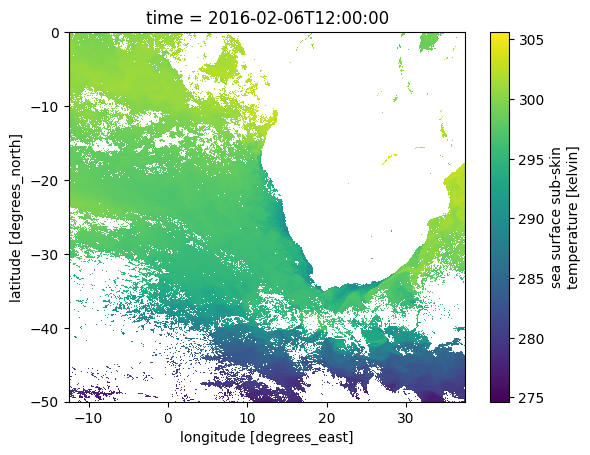

In [6]:
# plot this section, look for the exact point to the left of land mass

ds = xarray.Dataset(section)
ds['sea_surface_temperature'].plot()
plt.show()

In [7]:
# filter data set to not include polar regions

lat_min = -57
lat_max = 57

data_xr = data_xr.sel(lat=slice(lat_max, lat_min))
variable = data_xr['sea_surface_temperature']

In [8]:
# create subarray from variable filtered data, need less than 2% masked pixels

subarray_size = 192
max_nan_pixels = subarray_size ** 2 * 0.02 # we can have a max of 737 masked pixels

nan_mask = np.isnan(data_xr['sea_surface_temperature'])

# nan_mask.mean()
# (nan_mask == False).sum()
# In this entire region, we can see that land values take on "nan" for sst

In [9]:
# extract region surrounding target area (since we know it should have less than 2% masked)

target_latitude = -25.6
target_longitude = 12.21

subarray_size = 192
pixel_size = variable.lon[1] - variable.lon[0]
subarray_size_degrees = subarray_size * pixel_size # not sure about the correct conversion method!

half_size_degrees = subarray_size_degrees / 2

subarray = variable.sel(lat=slice(target_latitude + half_size_degrees, target_latitude - half_size_degrees),
                    lon=slice(target_longitude - half_size_degrees, target_longitude + half_size_degrees))


In [10]:
# now check the masking percentage in this subarray

# np.isnan(subarray).mean() # perfect, only 0.00121438!

# np.isnan(subarray).sum()

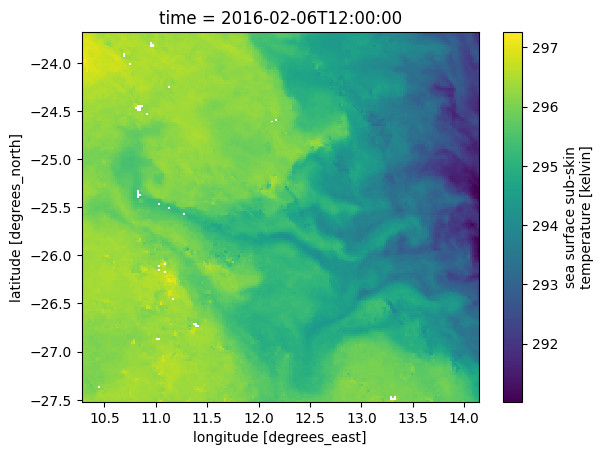

In [11]:
# plot this region

subarray.plot()
plt.show()

In [12]:
# across this grid, what is the average sea surface temperature? 

print(subarray.mean())
# the mean temperature is 295.13007, should I be converting this to Celsius? 
# in the Nautilus data set, the temperature for this region should be 22.454, which is 295.604 Kelvin
# I don't know if this subarray is the right pixel dimensions


<xarray.DataArray 'sea_surface_temperature' ()>
array(295.13007, dtype=float32)
